In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')

# Install if not already installed
!pip install xgboost
!pip install catboost
!pip install imbalanced-learn
!pip install prettytable
!pip install plotly

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, make_scorer
from imblearn.metrics import geometric_mean_score

# Import Dataset

In [3]:
data = pd.read_csv('Customer Churn Dataset.csv')

# Data Preprocessing

In [4]:
data["TotalCharges"] = data["TotalCharges"].replace(" ","0")
data["TotalCharges"] = data["TotalCharges"].astype("float")
data = data.drop(['customerID'], axis=1)
data[data['tenure'] == 0].index
data.drop(labels=data[data['tenure'] == 0].index, axis=0, inplace=True)
data[data['tenure'] == 0].index
data.fillna(data["TotalCharges"].mean())
data["SeniorCitizen"]= data["SeniorCitizen"].map({0: "No", 1: "Yes"})

In [5]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [6]:
data = data.apply(lambda x: object_to_int(x))
data = data.drop(['PhoneService','MonthlyCharges'], axis=1)

In [7]:
num_cols = ["tenure", 'TotalCharges']
data_std = pd.DataFrame(StandardScaler().fit_transform(data[num_cols].astype('float64')),
                       columns=num_cols)

In [8]:
cat_cols_ohe =['PaymentMethod', 'Contract', 'InternetService'] # those that need one-hot encoding
cat_cols_le = list(set(data.columns)- set(num_cols) - set(cat_cols_ohe)) #those that need label encoding

In [9]:
scaler= StandardScaler()
data[num_cols] = scaler.fit_transform(data_std[num_cols])

In [10]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,0,0,1,0,-1.280248,1,0,0,2,0,0,0,0,0,1,2,-0.994194,0
1,1,0,0,0,0.064303,0,0,2,0,2,0,0,0,1,0,3,-0.173740,0
2,1,0,0,0,-1.239504,0,0,2,2,0,0,0,0,0,1,3,-0.959649,1
3,1,0,0,0,0.512486,1,0,2,0,2,2,0,0,1,0,0,-0.195248,0
4,0,0,0,0,-1.239504,0,1,0,0,0,0,0,0,0,1,2,-0.940457,1


In [11]:
X = data.drop(columns=['Churn'])
y = data['Churn']

# Test-Train Split Before Cross Validation

In [12]:
# Separate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Logistic Regression Model (Using Cross Validation)

In [13]:
# Logistic Regression model defintion
model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=50)

In [14]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from imblearn.metrics import geometric_mean_score

# Initialize Stratified K-Fold
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

# Lists to store cross-validation metrics
cv_auc, cv_precision, cv_recall, cv_f1, cv_balanced_acc, cv_gmean = [], [], [], [], [], []

# Cross-validation loop
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = model.predict(X_val_fold)
    y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    cv_precision.append(precision_score(y_val_fold, y_pred))
    cv_recall.append(recall_score(y_val_fold, y_pred))
    cv_f1.append(f1_score(y_val_fold, y_pred))
    cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(cv_auc),
        np.mean(cv_precision),
        np.mean(cv_recall),
        np.mean(cv_f1),
        np.mean(cv_balanced_acc),
        np.mean(cv_gmean),
    ],
    "Standard Deviation": [
        np.std(cv_auc),
        np.std(cv_precision),
        np.std(cv_recall),
        np.std(cv_f1),
        np.std(cv_balanced_acc),
        np.std(cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
cv_results_df = pd.DataFrame(cv_results)

# Display the table
print("\nCross-Validation Metrics (Logistic Regression) :")
print(cv_results_df)


Cross-Validation Metrics (Logistic Regression) :
              Metric      Mean  Standard Deviation
0                AUC  0.838211            0.018167
1          Precision  0.493426            0.018771
2             Recall  0.817862            0.025779
3           F1 Score  0.615358            0.019731
4  Balanced Accuracy  0.753108            0.017403
5     Geometric Mean  0.750182            0.017143


In [15]:
import pandas as pd

# Train the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute metrics for the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_gmean = geometric_mean_score(y_test, y_test_pred)

# Store the test metrics in a DataFrame
test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [test_auc, test_precision, test_recall, test_f1, test_balanced_acc, test_gmean]
}

test_results_df = pd.DataFrame(test_results)

# Display the table
print("\nTest Set Metrics:")
print(test_results_df)


Test Set Metrics:
              Metric     Value
0                AUC  0.834652
1          Precision  0.457600
2             Recall  0.821839
3           F1 Score  0.587873
4  Balanced Accuracy  0.750863
5     Geometric Mean  0.747501


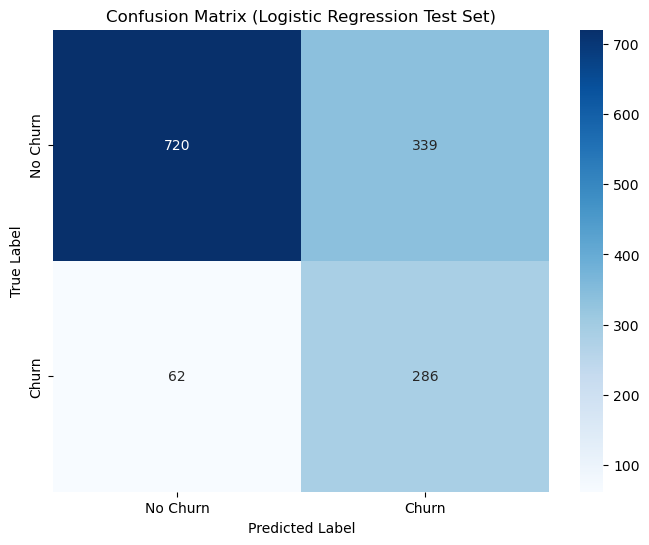

In [16]:
# Compute the confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)
# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Logistic Regression Test Set)')
plt.show()

# SVC using CV

In [17]:
from sklearn.svm import SVC

# Initializing the SVC model with probability=True for AUC computation
svc_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=50)

In [18]:
# Initialize Stratified K-Fold
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

# Lists to store cross-validation metrics
svc_cv_auc, svc_cv_precision, svc_cv_recall, svc_cv_f1, svc_cv_balanced_acc, svc_cv_gmean = [], [], [], [], [], []

# Cross-validation loop
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    svc_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = svc_model.predict(X_val_fold)
    y_pred_proba = svc_model.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    svc_cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    svc_cv_precision.append(precision_score(y_val_fold, y_pred))
    svc_cv_recall.append(recall_score(y_val_fold, y_pred))
    svc_cv_f1.append(f1_score(y_val_fold, y_pred))
    svc_cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    svc_cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
svc_cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(svc_cv_auc),
        np.mean(svc_cv_precision),
        np.mean(svc_cv_recall),
        np.mean(svc_cv_f1),
        np.mean(svc_cv_balanced_acc),
        np.mean(svc_cv_gmean),
    ],
    "Standard Deviation": [
        np.std(svc_cv_auc),
        np.std(svc_cv_precision),
        np.std(svc_cv_recall),
        np.std(svc_cv_f1),
        np.std(svc_cv_balanced_acc),
        np.std(svc_cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
svc_cv_results_df = pd.DataFrame(svc_cv_results)

# Display the table
print("\nCross-Validation Metrics (SVC) :")
print(svc_cv_results_df)


Cross-Validation Metrics (SVC) :
              Metric      Mean  Standard Deviation
0                AUC  0.839199            0.017841
1          Precision  0.471271            0.016597
2             Recall  0.855998            0.025466
3           F1 Score  0.607695            0.017496
4  Balanced Accuracy  0.749759            0.016345
5     Geometric Mean  0.741996            0.016334


In [19]:
# Train the model on the entire training set
svc_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred_svc = svc_model.predict(X_test)
y_test_pred_proba_svc = svc_model.predict_proba(X_test)[:, 1]


# Compute metrics for the test set
svc_test_auc = roc_auc_score(y_test, y_test_pred_proba_svc)
svc_test_precision = precision_score(y_test, y_test_pred_svc)
svc_test_recall = recall_score(y_test, y_test_pred_svc)
svc_test_f1 = f1_score(y_test, y_test_pred_svc)
svc_test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred_svc)
svc_test_gmean = geometric_mean_score(y_test, y_test_pred_svc)

# Store the test metrics in a DataFrame
svc_test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [svc_test_auc, svc_test_precision, svc_test_recall, svc_test_f1, svc_test_balanced_acc, svc_test_gmean]
}

svc_test_results_df = pd.DataFrame(svc_test_results)


# Display the table
print("\nTest Set Metrics (SVC):")
print(svc_test_results_df)


Test Set Metrics (SVC):
              Metric     Value
0                AUC  0.836830
1          Precision  0.442308
2             Recall  0.859195
3           F1 Score  0.583984
4  Balanced Accuracy  0.751600
5     Geometric Mean  0.743858


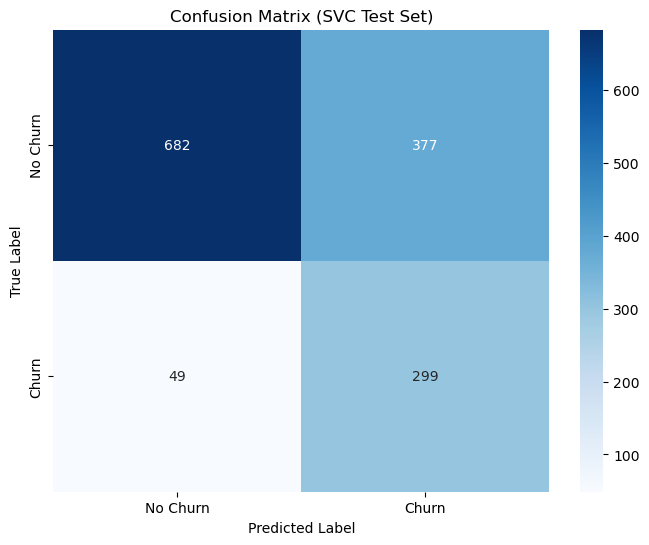

In [20]:

# Compute the confusion matrix
svc_test_cm = confusion_matrix(y_test, y_test_pred_svc)

# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(svc_test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVC Test Set)')
plt.show()

# Random forest using CV

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Initializing the Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1,
                                  random_state=50, max_features="sqrt", 
                                  max_leaf_nodes=30)

In [22]:
# Lists to store cross-validation metrics
cv_auc, cv_precision, cv_recall, cv_f1, cv_balanced_acc, cv_gmean = [], [], [], [], [], []

# Perform Stratified K-Fold Cross-Validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = rf_model.predict(X_val_fold)
    y_pred_proba = rf_model.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    cv_precision.append(precision_score(y_val_fold, y_pred))
    cv_recall.append(recall_score(y_val_fold, y_pred))
    cv_f1.append(f1_score(y_val_fold, y_pred))
    cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(cv_auc),
        np.mean(cv_precision),
        np.mean(cv_recall),
        np.mean(cv_f1),
        np.mean(cv_balanced_acc),
        np.mean(cv_gmean),
    ],
    "Standard Deviation": [
        np.std(cv_auc),
        np.std(cv_precision),
        np.std(cv_recall),
        np.std(cv_f1),
        np.std(cv_balanced_acc),
        np.std(cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
rf_cv_results_df = pd.DataFrame(cv_results)

# Display the table
print("\nCross-Validation Metrics (Random Forest):")
print(rf_cv_results_df)


Cross-Validation Metrics (Random Forest):
              Metric      Mean  Standard Deviation
0                AUC  0.844333            0.017977
1          Precision  0.672314            0.043639
2             Recall  0.460268            0.045863
3           F1 Score  0.544962            0.039290
4  Balanced Accuracy  0.688227            0.022308
5     Geometric Mean  0.648429            0.032038


In [23]:
# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = rf_model.predict(X_test)
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute metrics for the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_gmean = geometric_mean_score(y_test, y_test_pred)

# Store the test metrics in a DataFrame
test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [test_auc, test_precision, test_recall, test_f1, test_balanced_acc, test_gmean]
}

rf_test_results_df = pd.DataFrame(test_results)

# Display the table
print("\nTest Set Metrics (Random Forest):")
print(rf_test_results_df)


Test Set Metrics (Random Forest):
              Metric     Value
0                AUC  0.839220
1          Precision  0.650558
2             Recall  0.502874
3           F1 Score  0.567261
4  Balanced Accuracy  0.707055
5     Geometric Mean  0.676932


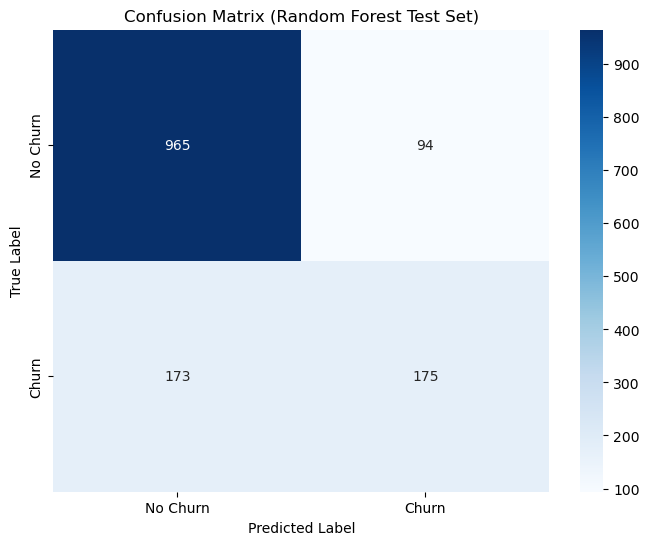

In [24]:
# Compute the confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest Test Set)')
plt.show()

# CatBoost using CV

In [25]:
from catboost import CatBoostClassifier

# Initializing the CatBoost model
catboost_model = CatBoostClassifier(
    iterations=500, 
    depth=6, 
    learning_rate=0.1, 
    loss_function='Logloss', 
    verbose=0, 
    random_seed=50, 
    class_weights=[1, len(y_train) / sum(y_train)]  # Handling class imbalance
)


In [26]:
# Lists to store cross-validation metrics
cv_auc, cv_precision, cv_recall, cv_f1, cv_balanced_acc, cv_gmean = [], [], [], [], [], []

# Perform Stratified K-Fold Cross-Validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    catboost_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = catboost_model.predict(X_val_fold)
    y_pred_proba = catboost_model.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    cv_precision.append(precision_score(y_val_fold, y_pred))
    cv_recall.append(recall_score(y_val_fold, y_pred))
    cv_f1.append(f1_score(y_val_fold, y_pred))
    cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(cv_auc),
        np.mean(cv_precision),
        np.mean(cv_recall),
        np.mean(cv_f1),
        np.mean(cv_balanced_acc),
        np.mean(cv_gmean),
    ],
    "Standard Deviation": [
        np.std(cv_auc),
        np.std(cv_precision),
        np.std(cv_recall),
        np.std(cv_f1),
        np.std(cv_balanced_acc),
        np.std(cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
catboost_cv_results_df = pd.DataFrame(cv_results)

# Display the table
print("\nCross-Validation Metrics (CatBoost):")
print(catboost_cv_results_df)


Cross-Validation Metrics (CatBoost):
              Metric      Mean  Standard Deviation
0                AUC  0.825210            0.016024
1          Precision  0.529257            0.031333
2             Recall  0.728500            0.027226
3           F1 Score  0.612802            0.028451
4  Balanced Accuracy  0.743637            0.022676
5     Geometric Mean  0.743354            0.022691


In [27]:
# Train the model on the entire training set
catboost_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = catboost_model.predict(X_test)
y_test_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# Compute metrics for the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_gmean = geometric_mean_score(y_test, y_test_pred)

# Store the test metrics in a DataFrame
test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [test_auc, test_precision, test_recall, test_f1, test_balanced_acc, test_gmean]
}

catboost_test_results_df = pd.DataFrame(test_results)

# Display the table
print("\nTest Set Metrics (CatBoost):")
print(catboost_test_results_df)


Test Set Metrics (CatBoost):
              Metric     Value
0                AUC  0.821682
1          Precision  0.483810
2             Recall  0.729885
3           F1 Score  0.581901
4  Balanced Accuracy  0.736992
5     Geometric Mean  0.736957


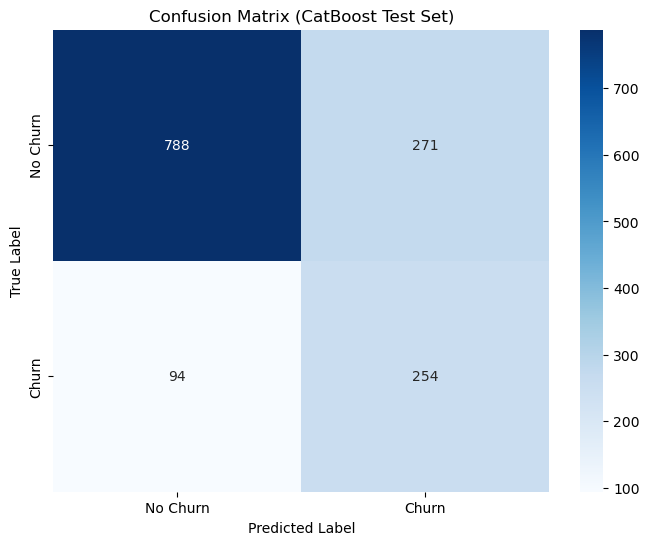

In [28]:
# Compute the confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (CatBoost Test Set)')
plt.show()

# CatBoost without data precprocessing

In [ ]:
#CatBoost without data processing
raw_data = pd.read_csv('Customer Churn Dataset.csv')
raw_data["TotalCharges"] = data["TotalCharges"].replace(" ","0")
raw_data["TotalCharges"] = data["TotalCharges"].astype("float")
raw_data.head()
X_raw = raw_data.drop(columns=['Churn','customerID'])
y_raw = raw_data['Churn']
# Convert y_raw to numeric
y_raw = y_raw.map({"Yes": 1, "No": 0})
X_raw.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Dani Alex Parayil\\Downloads\\MLProject\\WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [ ]:
# Separate the data into training and testing sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=50)

In [ ]:
from catboost import CatBoostClassifier

# Detect categorical variables
categorical_features = X_raw.select_dtypes(include=['object']).columns.tolist()

# Initialize the CatBoost model
catboost_model_raw = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    verbose=0,
    random_seed=50,
    class_weights=[1, len(y_raw) / sum(y_raw)],  # Adjust class imbalance
    cat_features=categorical_features
)

In [ ]:
# Cross-Validation Metrics
cv_auc, cv_precision, cv_recall, cv_f1, cv_balanced_acc, cv_gmean = [], [], [], [], [], []

# Perform Stratified K-Fold Cross-Validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

for train_index, val_index in skf.split(X_train_raw, y_train_raw):
    X_train_fold = X_train_raw.iloc[train_index]
    X_val_fold = X_train_raw.iloc[val_index]
    y_train_fold = y_train_raw.iloc[train_index]
    y_val_fold = y_train_raw.iloc[val_index]
    
    # Train the model on the training fold
    catboost_model_raw.fit(X_train_fold, y_train_fold, cat_features=categorical_features)
    
    # Predict on the validation fold
    y_pred = catboost_model_raw.predict(X_val_fold)
    y_pred_proba = catboost_model_raw.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    cv_precision.append(precision_score(y_val_fold, y_pred))
    cv_recall.append(recall_score(y_val_fold, y_pred))
    cv_f1.append(f1_score(y_val_fold, y_pred))
    cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(cv_auc),
        np.mean(cv_precision),
        np.mean(cv_recall),
        np.mean(cv_f1),
        np.mean(cv_balanced_acc),
        np.mean(cv_gmean),
    ],
    "Standard Deviation": [
        np.std(cv_auc),
        np.std(cv_precision),
        np.std(cv_recall),
        np.std(cv_f1),
        np.std(cv_balanced_acc),
        np.std(cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
catboost_cv_results_df = pd.DataFrame(cv_results)

# Display the CV metrics table
print("\nCross-Validation Metrics (CatBoost with Categorical Features):")
print(catboost_cv_results_df)


Cross-Validation Metrics (CatBoost with Categorical Features):
              Metric      Mean  Standard Deviation
0                AUC  0.834517            0.018835
1          Precision  0.529391            0.026417
2             Recall  0.743439            0.052117
3           F1 Score  0.617321            0.026153
4  Balanced Accuracy  0.751107            0.022683
5     Geometric Mean  0.750217            0.022886


In [ ]:
#Test Set Evaluation
# Train the model on the entire training set
catboost_model_raw.fit(X_train_raw, y_train_raw, cat_features=categorical_features)

# Predict on the test set
y_test_pred = catboost_model_raw.predict(X_test_raw)
y_test_pred_proba = catboost_model_raw.predict_proba(X_test_raw)[:, 1]

# Compute metrics for the test set
test_auc = roc_auc_score(y_test_raw, y_test_pred_proba)
test_precision = precision_score(y_test_raw, y_test_pred)
test_recall = recall_score(y_test_raw, y_test_pred)
test_f1 = f1_score(y_test_raw, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_raw, y_test_pred)
test_gmean = geometric_mean_score(y_test_raw, y_test_pred)

# Store the test metrics in a DataFrame
test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [test_auc, test_precision, test_recall, test_f1, test_balanced_acc, test_gmean]
}

catboost_test_results_df = pd.DataFrame(test_results)

# Display the test set metrics table
print("\nTest Set Metrics (CatBoost with Categorical Features):")
print(catboost_test_results_df)


Test Set Metrics (CatBoost with Categorical Features):
              Metric     Value
0                AUC  0.834825
1          Precision  0.525097
2             Recall  0.739130
3           F1 Score  0.613995
4  Balanced Accuracy  0.751410
5     Geometric Mean  0.751309


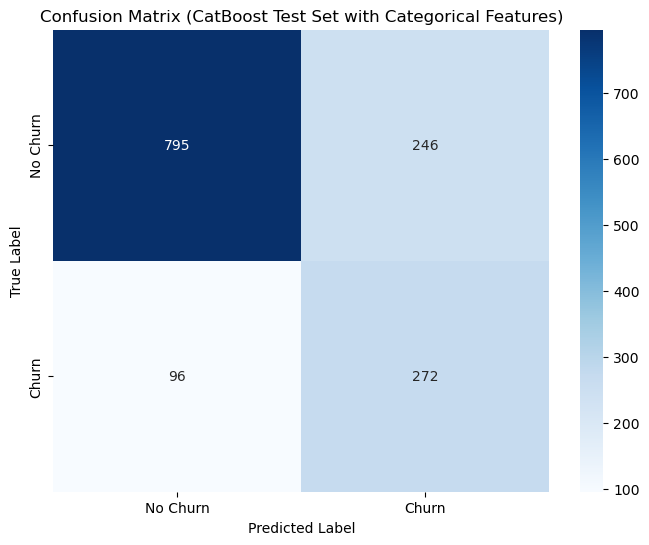

In [ ]:
# Compute the confusion matrix
test_cm = confusion_matrix(y_test_raw, y_test_pred)

# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (CatBoost Test Set with Categorical Features)')
plt.show()

# AdaBoost with CV

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Initializing the AdaBoost model
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=50)

In [ ]:
# Step 1: Cross-Validation Metrics
cv_auc, cv_precision, cv_recall, cv_f1, cv_balanced_acc, cv_gmean = [], [], [], [], [], []

# Perform Stratified K-Fold Cross-Validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    adaboost_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = adaboost_model.predict(X_val_fold)
    y_pred_proba = adaboost_model.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    cv_precision.append(precision_score(y_val_fold, y_pred))
    cv_recall.append(recall_score(y_val_fold, y_pred))
    cv_f1.append(f1_score(y_val_fold, y_pred))
    cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(cv_auc),
        np.mean(cv_precision),
        np.mean(cv_recall),
        np.mean(cv_f1),
        np.mean(cv_balanced_acc),
        np.mean(cv_gmean),
    ],
    "Standard Deviation": [
        np.std(cv_auc),
        np.std(cv_precision),
        np.std(cv_recall),
        np.std(cv_f1),
        np.std(cv_balanced_acc),
        np.std(cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
adaboost_cv_results_df = pd.DataFrame(cv_results)

# Display the CV metrics table
print("\nCross-Validation Metrics (AdaBoost):")
print(adaboost_cv_results_df)


Cross-Validation Metrics (AdaBoost):
              Metric      Mean  Standard Deviation
0                AUC  0.846827            0.015591
1          Precision  0.656412            0.029244
2             Recall  0.541813            0.043609
3           F1 Score  0.592811            0.033525
4  Balanced Accuracy  0.718275            0.021352
5     Geometric Mean  0.695614            0.027819


In [ ]:
# Step 2: Test Set Evaluation
# Train the model on the entire training set
adaboost_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = adaboost_model.predict(X_test)
y_test_pred_proba = adaboost_model.predict_proba(X_test)[:, 1]

# Compute metrics for the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_gmean = geometric_mean_score(y_test, y_test_pred)

# Store the test metrics in a DataFrame
test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [test_auc, test_precision, test_recall, test_f1, test_balanced_acc, test_gmean]
}

adaboost_test_results_df = pd.DataFrame(test_results)

# Display the test set metrics table
print("\nTest Set Metrics (AdaBoost):")
print(adaboost_test_results_df)


Test Set Metrics (AdaBoost):
              Metric     Value
0                AUC  0.840557
1          Precision  0.634615
2             Recall  0.568966
3           F1 Score  0.600000
4  Balanced Accuracy  0.730658
5     Geometric Mean  0.712543


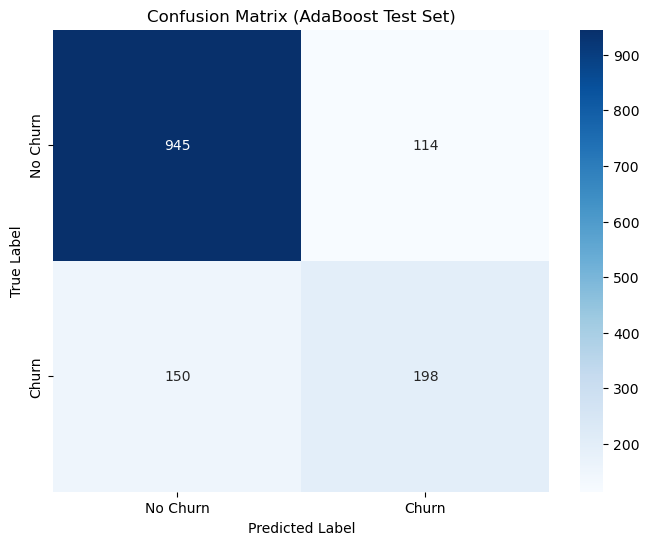

In [ ]:
# Step 3: Confusion Matrix
# Compute the confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (AdaBoost Test Set)')
plt.show()

# Gradient Boost with CV

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initializing the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=50
)

In [ ]:
# Step 1: Cross-Validation Metrics
cv_auc, cv_precision, cv_recall, cv_f1, cv_balanced_acc, cv_gmean = [], [], [], [], [], []

# Perform Stratified K-Fold Cross-Validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=50)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on the training fold
    gb_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred = gb_model.predict(X_val_fold)
    y_pred_proba = gb_model.predict_proba(X_val_fold)[:, 1]
    
    # Compute metrics for the validation fold
    cv_auc.append(roc_auc_score(y_val_fold, y_pred_proba))
    cv_precision.append(precision_score(y_val_fold, y_pred))
    cv_recall.append(recall_score(y_val_fold, y_pred))
    cv_f1.append(f1_score(y_val_fold, y_pred))
    cv_balanced_acc.append(balanced_accuracy_score(y_val_fold, y_pred))
    cv_gmean.append(geometric_mean_score(y_val_fold, y_pred))

# Compute mean and standard deviation of cross-validation metrics
cv_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Mean": [
        np.mean(cv_auc),
        np.mean(cv_precision),
        np.mean(cv_recall),
        np.mean(cv_f1),
        np.mean(cv_balanced_acc),
        np.mean(cv_gmean),
    ],
    "Standard Deviation": [
        np.std(cv_auc),
        np.std(cv_precision),
        np.std(cv_recall),
        np.std(cv_f1),
        np.std(cv_balanced_acc),
        np.std(cv_gmean),
    ],
}

# Create a DataFrame for the CV metrics
gb_cv_results_df = pd.DataFrame(cv_results)

# Display the CV metrics table
print("\nCross-Validation Metrics (Gradient Boosting):")
print(gb_cv_results_df)


Cross-Validation Metrics (Gradient Boosting):
              Metric      Mean  Standard Deviation
0                AUC  0.848267            0.015196
1          Precision  0.656221            0.035788
2             Recall  0.526690            0.049636
3           F1 Score  0.583384            0.040507
4  Balanced Accuracy  0.712176            0.025169
5     Geometric Mean  0.686760            0.032985


In [ ]:
# Step 2: Test Set Evaluation
# Train the model on the entire training set
gb_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = gb_model.predict(X_test)
y_test_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Compute metrics for the test set
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_gmean = geometric_mean_score(y_test, y_test_pred)

# Store the test metrics in a DataFrame
test_results = {
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "Geometric Mean"],
    "Value": [test_auc, test_precision, test_recall, test_f1, test_balanced_acc, test_gmean]
}

gb_test_results_df = pd.DataFrame(test_results)

# Display the test set metrics table
print("\nTest Set Metrics (Gradient Boosting):")
print(gb_test_results_df)


Test Set Metrics (Gradient Boosting):
              Metric     Value
0                AUC  0.842658
1          Precision  0.630719
2             Recall  0.554598
3           F1 Score  0.590214
4  Balanced Accuracy  0.723947
5     Geometric Mean  0.703861


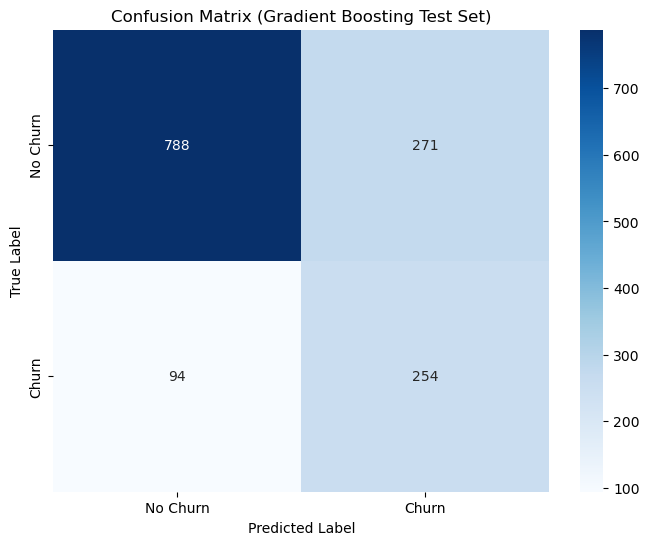

In [31]:
# Step 3: Confusion Matrix
# Compute the confusion matrix
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix with a blue theme
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Gradient Boosting Test Set)')
plt.show()